In [27]:
import torch
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import json
import os

from matplotlib.lines import Line2D

            
def load_profiles(dir_path):
    generate_profiles = []
    for filename in os.listdir(dir_path):
        if filename.endswith(".json"):
            file_path = os.path.join(dir_path, filename)
            with open(file_path, 'r') as file:
                generate_profiles.append(json.load(file))
    return generate_profiles

def calc_depth_accept_rate(profiles, depth, average=True):
    avg_accept_lens = []
    depth_accept_rates = []
    depth_total_cnt_rates = []
    
    for profile in profiles:
        sampled_lens = torch.tensor([len(sampled_tokens) for sampled_tokens in profile["iter"]], dtype=torch.int)
        sampled_len_bins = torch.bincount(sampled_lens, minlength=depth+1)
        depth_total_cnt = sampled_len_bins + sampled_len_bins.sum() - sampled_len_bins.cumsum(dim=-1) # reverse cumsum
        depth_accept_cnt = depth_total_cnt - sampled_len_bins
        depth_total_cnt = depth_total_cnt[1:depth]
        depth_accept_cnt = depth_accept_cnt[1:depth]
        
        avg_accept_lens.append(sampled_lens.float().mean())
        depth_accept_rates.append(depth_accept_cnt.float() / (depth_total_cnt.float()+1e-6))
        depth_total_cnt_rates.append(depth_total_cnt.float() / depth_total_cnt[0])
    
    if average:
        depth_accept_rates = [np.mean(depth_accept_rates, axis=0)]
    avg_depth_total_cnt_rate = np.mean(depth_total_cnt_rates, axis=0)
    
    return avg_accept_lens, depth_accept_rates, avg_depth_total_cnt_rate

def calc_node_accept_rate(profiles, depth, average=True):
    avg_accept_lens = []
    depth_accept_rates = []
    depth_total_cnt_rates = []
    
    for profile in profiles:
        sampled_lens = torch.tensor([len(sampled_tokens) for sampled_tokens in profile["iter"]], dtype=torch.int)
        
        for sampled_tokens in profile["iter"]:
            print(f'len(sampled_tokens): {len(sampled_tokens)}')
        print(f"profile[\'total_len\']: {profile['total_len']}")
        print(f"profile[\'accept_len\']: {profile['accept_len']}")
        total_lens = torch.bincount( torch.tensor(profile['total_len']), minlength=depth+1)
        accept_lens = torch.bincount( torch.tensor(profile['accept_len']), minlength=depth+1)
        depth_total_cnt = total_lens + total_lens.sum() - total_lens.cumsum(dim=-1) # reverse cumsum
        depth_accept_cnt = accept_lens + accept_lens.sum() - accept_lens.cumsum(dim=-1) # reverse cumsum
        depth_total_cnt = depth_total_cnt[1:depth] # remove first element
        depth_accept_cnt = depth_accept_cnt[1:depth] # remove first element
        
        avg_accept_lens.append(sampled_lens.float().mean())
        depth_accept_rates.append(depth_accept_cnt.float() / (depth_total_cnt.float()+1e-6))
        depth_total_cnt_rates.append(depth_total_cnt.float() / depth_total_cnt[0])
    
    if average:
        depth_accept_rates = [np.mean(depth_accept_rates, axis=0)]
    avg_depth_total_cnt_rate = np.mean(depth_total_cnt_rates, axis=0)
    
    return avg_accept_lens, depth_accept_rates, avg_depth_total_cnt_rate
    
       
def draw_avg_accept_len(ax, avg_accept_lens, color='#1f77b4', base=0, text_offset=0.001):
    for i, avg_accept_len in enumerate(avg_accept_lens):
        ax.plot(avg_accept_len, base, '|', label=i, color=color, alpha=0.2, markersize=10)
    # plot the average depth
    avg_accept_len = np.mean(avg_accept_lens)
    std_accept_len = np.std(avg_accept_lens)
    ax.text(0.5, base + text_offset, f'{avg_accept_len:.2f}±{std_accept_len*2:.2f}', fontsize=12, color=color)
        
def draw_alpha_line(ax, avg_alpha_records, tree_alpha_records, depth, color='#1f77b4', marker='o-', base=0, text_offset=0.001):
    # plot alpha of each depth
    for i in range(len(tree_alpha_records)):
        pt = ax.plot(np.arange(1, depth), tree_alpha_records[i], marker, label=f'profile_{i}', color=color, alpha=0.8)
        pt[0].set_markersize(8)
        pt[0].set_linewidth(1)

    draw_avg_accept_len(ax, avg_alpha_records, color=color, base=base, text_offset=text_offset)
    
#   def draw_alpha_line(ax, avg_alpha_records, tree_alpha_records, depth, color='#1f77b4', marker='o-', base=0, text_offset=0.001):
        

def draw_chart(accept_rate_data, depth, labels, colors, title, label_title=''):
    # plot the chart
    # fig, ax = plt.subplots()
    # plot two charts, one for alpha and one for cumulative total count
    fig = plt.figure(figsize=(10, 5))
    ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), rowspan=2)
    ax12 = plt.subplot2grid(shape=(2, 2), loc=(0, 1))
    ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 1))
    
    # plot alpha of each depth
    base = 0.40
    for i, alpha_data in enumerate(reversed(accept_rate_data)):
        draw_alpha_line(ax1, alpha_data[0], alpha_data[1], depth, color=colors[len(accept_rate_data)-i-1], marker='o-', base=base, text_offset=-0.01)
        base += 0.05
        
        ax2.plot(np.arange(1, depth), alpha_data[2], color=colors[len(accept_rate_data)-i-1], label=labels[i])
        
    # ax1 font size
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.set_xlabel('Depth', fontsize=16)
    ax1.set_ylabel('Tree Acceptance Rate', fontsize=16)
    # set x-axis
    ax1.set_xlim(0, depth)
    ax1.set_xticks(np.arange(1, depth))
    # set y-axis
    min_show_prob = 0.4
    ax1.set_ylim(min_show_prob-0.05, 1.02)
    ax1.set_yticks(np.arange(min_show_prob, 1.1, 0.1))
    
    # ax2 font size
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.set_xlabel('Depth', fontsize=16)
    ax2.set_ylabel('Alive Ratio', fontsize=16)
    # set x-axis
    ax2.set_xlim(0, depth)
    ax2.set_xticks(np.arange(1, depth))
    # set y-axis
    ax2.set_yticks(np.arange(0, 1.2, 0.2))
    
    
    # title
    ax1.set_title(title, fontsize=16)
    ax2.set_title('Cumulative Total Count Rate', fontsize=16)

    # custom legend
    legend_elements = []
    for i in range(len(accept_rate_data)):
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=labels[i], markerfacecolor=colors[i], markersize=8))
    ax12.legend(handles=legend_elements, loc='center left', fontsize=14, title=label_title, title_fontsize=14)#, bbox_to_anchor=(1, 0.85))
    ax12.axis('off') # hide x-axis and y-axis
    
    
    
    plt.tight_layout()
    # plt.show()
    # higher dpi
    plt.savefig(f'{title}.png', dpi=300)

ValueError: x and y must have same first dimension, but have shapes (11,) and (1,)

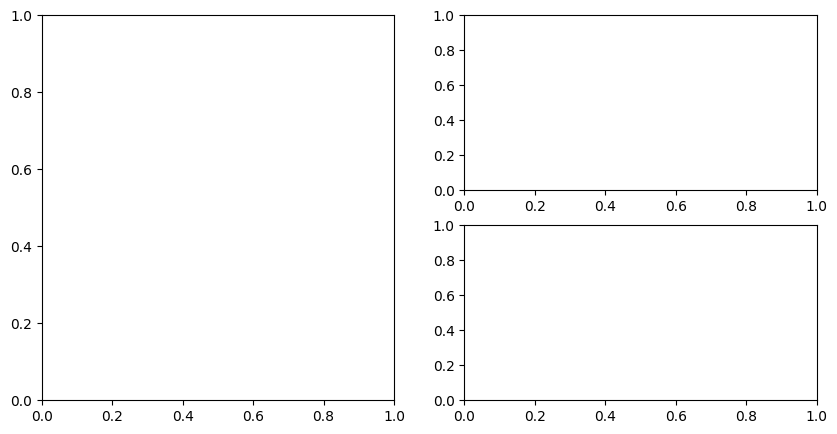

In [28]:
depth = 12 
profile_dirs = [
    "specdecodes/experiments/profile_data",
]
labels = [
    "SpecX LLM(Llama2-7B) + SSM(TinyLlama1.1B)",
]
# colors = ['#2d6a4f', '#023e7d', '#1e88e5', '#f9c74f']
colors = ['#1e88e5', ]

accept_rate_data = []
for profile_dir in profile_dirs:
    accept_rate_data.append(calc_depth_accept_rate(load_profiles(profile_dir), depth, average=True))
title='Depth Acceptance Rate (topk-d12k16)'
label_title='SpecX'
draw_chart(accept_rate_data, depth, labels, colors, title=title, label_title=label_title)

accept_rate_data = []
for profile_dir in profile_dirs:
    accept_rate_data.append(calc_node_accept_rate(load_profiles(profile_dir), depth, average=True))
title='Node Acceptance Rate (topk-d12k16)'
label_title='SpecX'
draw_chart(accept_rate_data, depth, labels, colors, title=title, label_title=label_title)